## 1. Download Dataset

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [139]:
import os
os.makedirs("/content/datasets", exist_ok=True)
os.replace("/content/kaggle.json", "/content/datasets/kaggle.json")
os.environ['KAGGLE_CONFIG_DIR'] = "/content/datasets"

In [141]:
!kaggle datasets download -d jessicali9530/celeba-dataset --force

100% 1.33G/1.33G [00:13<00:00, 144MB/s]
100% 1.33G/1.33G [00:13<00:00, 102MB/s]


In [ ]:
!chmod 600 /content/kaggle.json

In [ ]:
from zipfile import ZipFile
with ZipFile('celeba-dataset.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall()

## 2.

In [124]:
from torch.utils.data import Dataset
from torchvision.datasets import CelebA
from PIL import Image
from tqdm import tqdm
from glob import glob

import os
import shutil

import pandas as pd
import numpy as np


data_split = {
    0: 'train',
    1: 'valid',
    2: 'test'
}

class CelebADataset(CelebA):
    def __init__(
            self,
            **kwargs,
    ) -> None:
        super().__init__(**kwargs)
        self.split = kwargs["split"]


        self.target_attribute = "Blond_Hair"
        self.transform = kwargs["transform"]
        self.confounder =  "Male"
        # self.split = split
        # self.target_transform = target_transform
        # self.return_confounder = return_confounder
        # self.return_masked = False
        self.data_path = {}
        # self.masked_data_path = []
        self.labels = {}
        self.confounders = {}
        self.split = kwargs["split"]
        self.raw_data_path = ''
        self.root = kwargs["root"]

        if (self.split=="train"):
            self.img_data_dir = os.path.join(
                kwargs["root"],
                self.split)
        elif (self.split=="test"):
            self.img_data_dir = os.path.join(
                kwargs["root"],
                self.split)
        else:
            self.img_data_dir = os.path.join(
                kwargs["root"],
                self.split)
        


        if not (os.path.isdir(self.img_data_dir) and len(os.listdir(self.img_data_dir)) > 0):
            print(
                f"\n\nstart creating and saving {self.split} dataset of CelebA\n\n")
            attrs_df = pd.read_csv(os.path.join(
                self.raw_data_path, 'list_attr_celeba.csv'))

            # Salvo gli ids e li rimuovo dal dataset
            image_ids = attrs_df['image_id'].values
            attrs_df = attrs_df.drop(labels='image_id', axis='columns')

            # Prendo i nomi degli attributi
            attr_names = attrs_df.columns.copy()
            attrs_df = attrs_df.values
            
            attrs_df[attrs_df == -1] = 0

            # Setto il parametro target
            target_idx = attr_names.get_loc(self.target_attribute)
            labels = attrs_df[:, target_idx]

            # Prendo il parametro confounder
            confounder_idx = attr_names.get_loc(self.confounder)
            confounders = attrs_df[:, confounder_idx]

            # Partiziono gli elementi del dataset a seconda di quale set faranno parte {train, test, validation}
            partition_df = pd.read_csv(os.path.join(
                self.raw_data_path, 'list_eval_partition.csv'))
            partitions = partition_df['partition']

            os.makedirs(self.img_data_dir, exist_ok=True)


            for image_id, label, confounder, partition in tqdm(zip(image_ids, labels, confounders, partitions), total=len(image_ids)):
                if data_split[partition] == self.split:
                  # Create training Dataset
                  shutil.copy(os.path.join('img_align_celeba', 'img_align_celeba', image_id), os.path.join(
                      self.img_data_dir, image_id))
                  # self.data_path.append(os.path.join(self.img_data_dir, image_id))
                  # self.labels = np.append(self.labels,int(label))
                  self.data_path[int(image_id.split('.')[-2])] = os.path.join(self.img_data_dir, image_id)
                  self.labels[int(image_id.split('.')[-2])] = int(label)
                  self.confounders[int(image_id.split('.')[-2])] = confounder
                  # Create validation Dataset
                
            print(f"\n\nfinished creating and saving {self.split} dataset of CelebA\n\n")
            return


        attrs_df = pd.read_csv(os.path.join(
                self.raw_data_path, 'list_attr_celeba.csv'))

        # Salvo gli ids e li rimuovo dal dataset
        image_ids = attrs_df['image_id'].values
        attrs_df = attrs_df.drop(labels='image_id', axis='columns')

        # Prendo i nomi degli attributi
        attr_names = attrs_df.columns.copy()
        attrs_df = attrs_df.values
            
        attrs_df[attrs_df == -1] = 0

        # Setto il parametro target
        target_idx = attr_names.get_loc(self.target_attribute)
        labels = attrs_df[:, target_idx]

        # Prendo il parametro confounder
        confounder_idx = attr_names.get_loc(self.confounder)
        confounders = attrs_df[:, confounder_idx]

        # Partiziono gli elementi del dataset a seconda di quale set faranno parte {train, test, validation}
        partition_df = pd.read_csv(os.path.join(
          self.raw_data_path, 'list_eval_partition.csv'))
        partitions = partition_df['partition']

        for image_id, label, confounder, partition in tqdm(zip(image_ids, labels, confounders, partitions), total=len(image_ids)):
          if data_split[partition] == self.split:
            self.data_path[int(image_id.split('.')[-2])] = os.path.join(self.img_data_dir, image_id)
            self.labels[int(image_id.split('.')[-2])] = int(label)
            self.confounders[int(image_id.split('.')[-2])] = confounder

                 
        print(f"\n\nfinished creating and saving {self.split} dataset of CelebA\n\n")    

    


    def __getitem__(self, index: int):

      # Using id, you take image and label related to that value
      img_file_path, label = self.data_path[index], self.labels[index]

      # Obtain image from the path
      img = Image.open(img_file_path)
          
      if self.transform is not None:
        img = self.transform(img)
          
      confounder = self.confounders[index]
          
      return img, img_file_path, label, confounder

        

In [125]:
from torchvision.transforms import transforms
orig_w = 178
orig_h = 218
orig_min_dim = min(orig_w, orig_h)
target_resolution = (224, 224)
transform_test = transforms.Compose([
                    transforms.CenterCrop(orig_min_dim),
                    transforms.Resize(target_resolution),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])

In [126]:
train_dataset = CelebADataset(
                # raw_data_path='CelebA',
                root='data/',
                split="train",
                transform=transform_test,
                download=True,

                )

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]



start creating and saving train dataset of CelebA




100%|██████████| 202599/202599 [00:49<00:00, 4116.25it/s]  



finished creating and saving train dataset of CelebA




In [127]:
valid_dataset = CelebADataset(
                # raw_data_path='CelebA',
                root='data/',
                split="valid",
                transform=transform_test,
                download=True,

                )

Files already downloaded and verified


start creating and saving valid dataset of CelebA




100%|██████████| 202599/202599 [00:05<00:00, 35920.66it/s]  



finished creating and saving valid dataset of CelebA




In [128]:
test_dataset = CelebADataset(
                # raw_data_path='CelebA',
                root='data/',
                split="test",
                transform=transform_test,
                download=True,
                )

Files already downloaded and verified


start creating and saving test dataset of CelebA




100%|██████████| 202599/202599 [00:05<00:00, 37218.48it/s]  



finished creating and saving test dataset of CelebA




In [142]:
x = train_dataset.__getitem__(1)
y = test_dataset.__getitem__(190000)
z = valid_dataset.__getitem__(163686)

In [144]:
import torch
train_loader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=512,
                shuffle=True,
                num_workers=1
            )
train_loader

In [131]:
print(y)

(tensor([[[-0.6452, -0.6623, -0.6623,  ..., -0.5253, -0.5253, -0.5253],
         [-0.6281, -0.6452, -0.6452,  ..., -0.5253, -0.5253, -0.5253],
         [-0.6109, -0.6281, -0.6281,  ..., -0.5253, -0.5253, -0.5253],
         ...,
         [-1.6727, -1.6898, -1.6898,  ..., -1.5528, -1.5185, -1.5185],
         [-1.6727, -1.6898, -1.7069,  ..., -1.5528, -1.5357, -1.5357],
         [-1.7754, -1.7754, -1.7754,  ..., -1.5699, -1.5528, -1.5528]],

        [[-0.3025, -0.3200, -0.3200,  ..., -0.6001, -0.6176, -0.6176],
         [-0.2850, -0.3025, -0.3025,  ..., -0.6001, -0.6176, -0.6176],
         [-0.2675, -0.2850, -0.2850,  ..., -0.6001, -0.6176, -0.6176],
         ...,
         [-1.5630, -1.5805, -1.5980,  ..., -1.6856, -1.6681, -1.6681],
         [-1.5805, -1.5980, -1.6155,  ..., -1.6856, -1.6681, -1.6681],
         [-1.6856, -1.6856, -1.7031,  ..., -1.6681, -1.6506, -1.6506]],

        [[-0.8284, -0.8458, -0.8458,  ..., -0.5844, -0.6018, -0.6018],
         [-0.8110, -0.8284, -0.8284,  ..., -

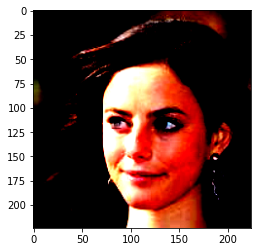

In [133]:
import matplotlib.pyplot as plt
plt.imshow(y[0].transpose(0,1).transpose(1,2))

In [123]:
!rm data -r

In [135]:
len(valid_dataset.data_path)

19867